Attrition
No     1233
Yes     237
Name: count, dtype: int64

Department
Human Resources           0.210526
Research & Development    0.150965
Sales                     0.234994
dtype: float64

PerformanceRating
3    0.177699
4    0.181373
dtype: float64

Generation
Boomers    0.131313
GenX       0.109434
GenZ&M     0.236974
dtype: float64

[0.17133713 0.06778293]
[0.17461668 0.06866064]
[0.16818776 0.06584372]


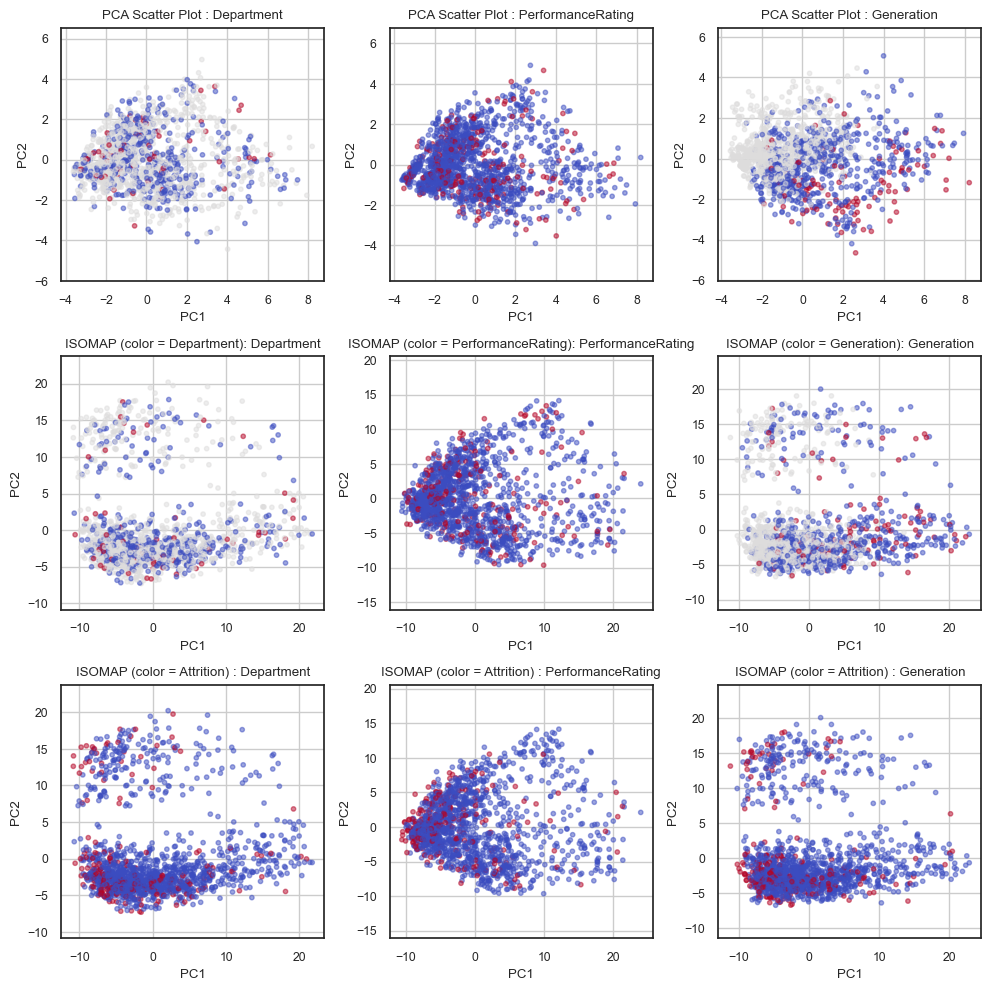

F-statistic Department:  5.426843272582724
p-value Department: 0.004485674813058454

F-statistic PerformanceRating:  0.01225039553422336
p-value PerformanceRating: 0.9118840421067758

F-statistic Generation:  14.520649244449514
p-value Generation: 5.693387735335216e-07

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EnvironmentSatisfaction   1470 non-null   int64 
 8   Gender                    1470 non-null   object
 9   JobInvolvement         

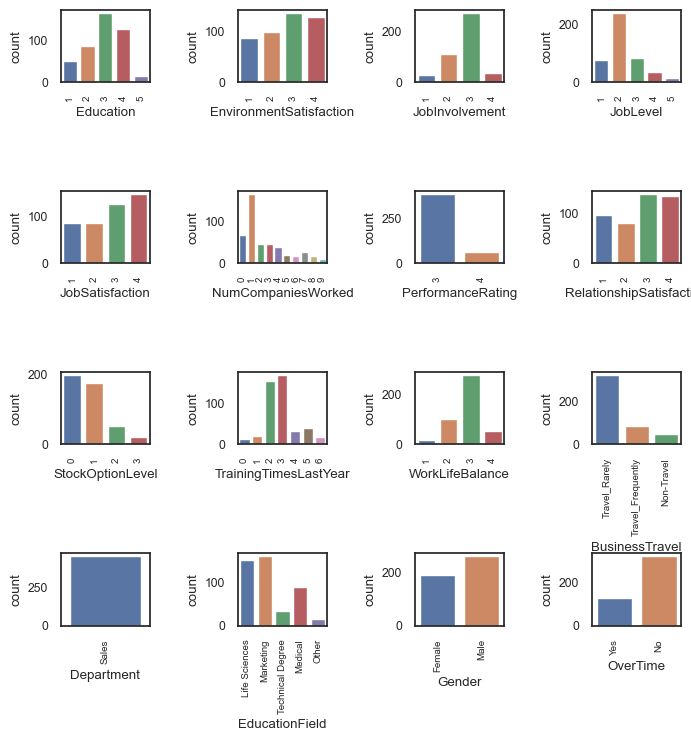

In [189]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.manifold import Isomap
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import f_oneway
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.linear_model import LassoCV # To find the optimal value of alpha,use lassoCV
from sklearn.linear_model import Lasso 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier

os.getcwd()

data = pd.read_csv("dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# missing data check
data = data.copy()
data.describe().transpose()
#data.info()
data.head()
data.loc[data.isna().any(axis=1),] # False , no na values

# Attrition count check
print(data["Attrition"].value_counts()) # No     1233, Yes     237
print()

# attrition rate check for each categories
category_check_data = data.copy()
category_check_data["Generation"] = category_check_data.apply(lambda x : "GenZ&M" if x["Age"] <= 36 else ("GenX" if (x["Age"] > 36 and x["Age"] <= 52) else "Boomers"), axis=1)
category = ["Department", "PerformanceRating", "Generation"]

for i in category :
    total_ppl = category_check_data.groupby(i).size()
    attr_y = category_check_data.groupby(i).apply(lambda group : group[group["Attrition"]=="Yes"].count())["Attrition"] 
    new_hires = category_check_data.groupby(i).apply(lambda group : group[group["YearsAtCompany"]==0].count())["YearsAtCompany"]
    start_ppl = total_ppl - new_hires
    end_ppl = start_ppl - attr_y + new_hires
    attr_rate = attr_y/((start_ppl + end_ppl)/2)
    print(attr_rate)
    print()


# attrition transformation to binary
category_check_data["Attrition"] = category_check_data["Attrition"].apply(lambda x : 1 if x == "Yes" else 0)
fig, ax = plt.subplots(3, 3, figsize = (10, 10))

# Check PCA, ISOMAP for each category
for i in range(len(category)) :
    row = i // 3
    col = i % 3
    
    unique_cate = category_check_data[category[i]].unique()
    #print(unique_cate)
    category_mapping = {cate: j+1 for j, cate in enumerate(unique_cate)}
    #print(category_mapping)
    category_check = category_check_data[category[i]].replace(category_mapping) 
 
    data_pca_check = pd.get_dummies(category_check_data.drop(columns = category[i]).drop(columns=["Attrition"])) 
    data_numeric_col = data_pca_check.select_dtypes(include=['int64', 'float64']).columns
    data_pca_check[data_numeric_col] = StandardScaler().fit(data_pca_check[data_numeric_col]).transform(data_pca_check[data_numeric_col]) 
    #data_pca_check.info()
    
    # PCA
    pca = PCA(n_components =2).fit(data_pca_check)
    pc = pca.transform(data_pca_check)
    print(pca.explained_variance_ratio_) 
    
    ax[row, col].scatter(pc[:,0], pc[:,1], s=10, c=category_check, alpha=0.5, cmap="coolwarm")
    # #sns.scatterplot(x='PC1', y='PC2', hue=, data=pca_df)

    ax[row, col].set_title(f'PCA Scatter Plot : {category[i]}')
    ax[row, col].set_xlabel('PC1')  
    ax[row, col].set_ylabel('PC2')
    ax[row, col].axis('equal')
    ax[row, col].grid()

    
    
    # ISOMAP
    isomap = Isomap(n_components=2, n_neighbors=5)
    X_reduced = isomap.fit_transform(data_pca_check)
    
    ax[row+1, col].scatter(X_reduced[:,0], X_reduced[:,1], s=10, c=category_check, alpha=0.5, cmap="coolwarm")
    # #sns.scatterplot(x='PC1', y='PC2', hue=, data=pca_df)

    ax[row+1, col].set_title(f'ISOMAP (color = {category[i]}): {category[i]}')
    ax[row+1, col].set_xlabel('PC1')  
    ax[row+1, col].set_ylabel('PC2')
    ax[row+1, col].axis('equal')
    ax[row+1, col].grid()
    
    
    
    # ISOMAP attrition
    isomap2 = Isomap(n_components=2, n_neighbors=5)
    X_reduced2 = isomap2.fit_transform(data_pca_check)
    
    ax[row+2, col].scatter(X_reduced2[:,0], X_reduced2[:,1], s=10, c=category_check_data["Attrition"], alpha=0.5, cmap="coolwarm")
    # #sns.scatterplot(x='PC1', y='PC2', hue=, data=pca_df)

    ax[row+2, col].set_title(f'ISOMAP (color = Attrition) : {category[i]}')
    ax[row+2, col].set_xlabel('PC1')  
    ax[row+2, col].set_ylabel('PC2')
    ax[row+2, col].axis('equal')
    ax[row+2, col].grid()
    
plt.tight_layout()  
plt.show()




# ANOVA 
for i in range(len(category)) :
    unique_cate = category_check_data[category[i]].unique()
    unique_cate_data = []
    #print(category_check_data[category_check_data[category[i]] == unique_cate[i]]['Attrition'].tolist())
    for j in unique_cate :
        unique_cate_data.append(category_check_data[category_check_data[category[i]] == j]['Attrition'].tolist())
    #print(unique_cate_data)
    f_statistic, p_value = f_oneway(*unique_cate_data)
    print(f"F-statistic {category[i]}: ", f_statistic)
    print(f"p-value {category[i]}:", p_value)
    print()




# preprocess 
data["Attrition"] = data["Attrition"].apply(lambda x : 1 if x == "Yes" else 0) 
sum(data["EmployeeNumber"].duplicated()) # 0, check employee duplication
# unnecessary features removal
data = data.drop(columns = ["EmployeeCount", "EmployeeNumber", "DailyRate", "HourlyRate", "MonthlyRate", "JobRole", "MaritalStatus", "Over18", "StandardHours"]) # for the simplicity of the problem, drop similar indicators of income other than monlty income
data.info()

numerical_categ_col = data[["Education", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel", "JobSatisfaction", 
                            "NumCompaniesWorked", "PerformanceRating", "RelationshipSatisfaction", "StockOptionLevel", 
                            "TrainingTimesLastYear", "WorkLifeBalance"]].columns
cate_col = data.select_dtypes(include=['object']).columns
cate_numerical_cate_col = list(numerical_categ_col)+list(cate_col)


# Department data creation
data_HR = data.loc[data["Department"]=="Human Resources",]
data_RnD = data.loc[data["Department"]=="Research & Development",]
data_Sales = data.loc[data["Department"]=="Sales",]
data_dept = data.loc[data["Department"]=="Sales",]


X_HR = data_HR.drop(columns = ["Attrition"])
X_RnD = data_RnD.drop(columns = ["Attrition"])
X_Sales = data_Sales.drop(columns = ["Attrition"])

y_HR = data_HR["Attrition"]
y_RnD = data_RnD["Attrition"]
y_Sales = data_Sales["Attrition"]




### SALES DATA FOCUS
# distribution check 
sns.set(font_scale=0.8)
sns.set_style("white")
#sns.set()
num_features = len(cate_numerical_cate_col) # 16
print(num_features)
fig, ax = plt.subplots(4,4, figsize=(8,8))
plt.subplots_adjust(wspace=1, hspace=1.5)  
for i in range(num_features) :
    row = i // 4
    col = i % 4
    sns.countplot(x=cate_numerical_cate_col[i], data=data_Sales, ax=ax[row, col])
    ax[row, col].tick_params(axis='x', rotation=90, labelsize=7)
plt.show()

In [ ]:
# Check ISOMAP with clustering
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=2, affinity='rbf', n_neighbors=5, random_state=42)
y_pred = spectral_clustering.fit_predict(X_reduced[:,:2])

# ISOMAP 
plt.figure()
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=10, c=y_pred, alpha=0.5, cmap="coolwarm")
plt.axis('equal')
plt.grid()
plt.show()

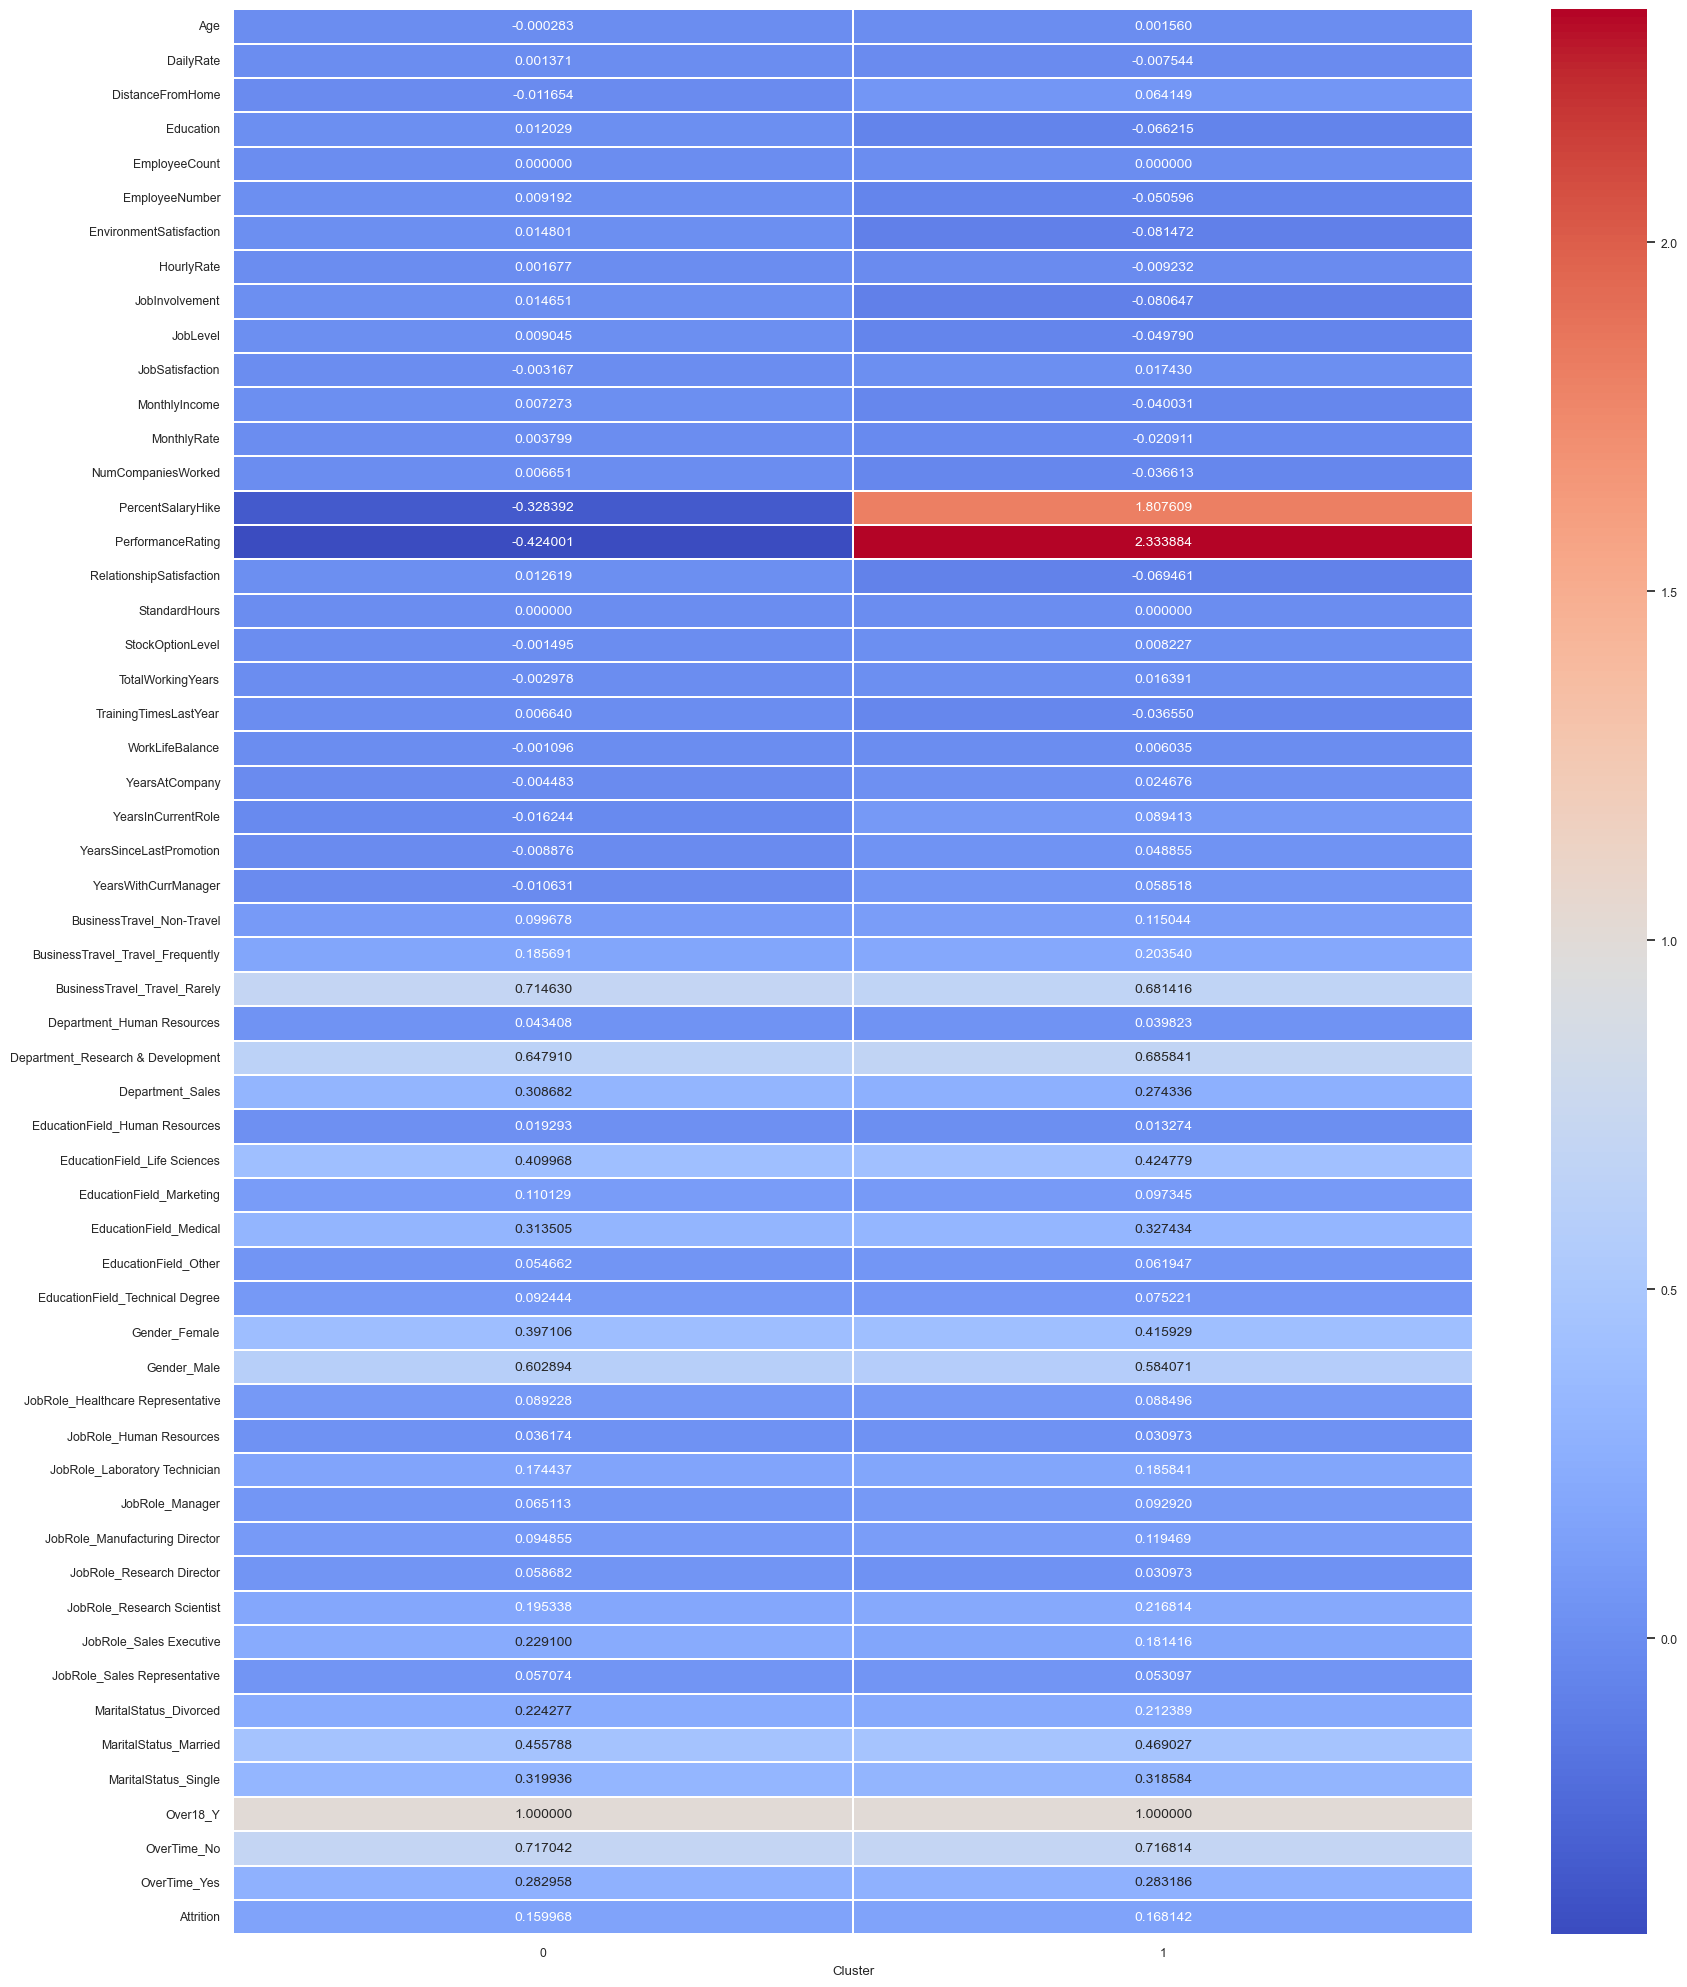

In [22]:
# clusters feature mean check
data_pca_check["Cluster"] = y_pred
data_pca_check["Attrition"]= category_check_data["Attrition"]

data_pca_check[data_pca_check["Cluster"]==1].mean()
#data_pca_check[data_pca_check["Attrition"]==1]
cluster_mean = data_pca_check.groupby(["Cluster"]).mean().T
plt.figure(figsize=(20, 25))
sns.heatmap(cluster_mean, annot = True, fmt='1f', linewidth = 0.1, annot_kws = {'fontsize':10}, cmap="coolwarm")
plt.show()

In [397]:
# Sales dept attrition count 
Sales_attriton = data.loc[data["Department"]=="Sales",]["Attrition"].value_counts()
Sales_attriton
# plt.figure(figsize=(4, 4))
# Sales_attriton.plot(kind='bar', color=['blue', 'red'])
# plt.title("Attrition Counts in Sales Department")
# plt.xlabel("Attrition")
# plt.ylabel("Counts")
# plt.xticks(rotation=0)
# plt.show()

Attrition
0    354
1     92
Name: count, dtype: int64

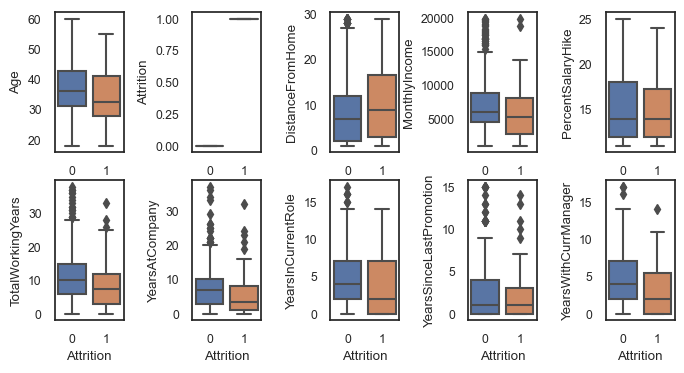

In [98]:
# numeric features box plot check
num_numeric_features = len(data_Sales.drop(columns = cate_numerical_cate_col).columns)
fig, ax = plt.subplots(2,5, figsize=(8,4))
plt.subplots_adjust(wspace=1) 
for i in range(num_numeric_features) :
    row = i // 5
    col = i % 5
#     sns.countplot(x=cate_numerical_cate_col[i], data=data_Sales, ax=ax[row, col])
    sns.boxplot(x = "Attrition", y = data_Sales.drop(columns = cate_numerical_cate_col).columns[i], data=data_Sales, ax=ax[row, col])
plt.show()


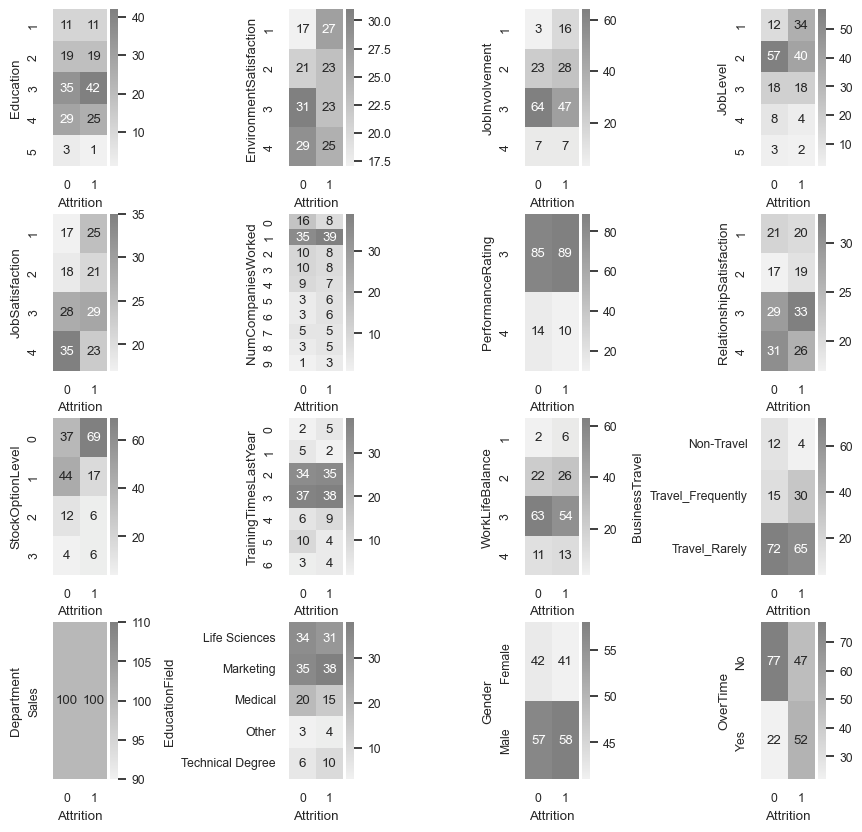

In [99]:
# categorical features, numeric with increasing order categories heatmaps
fig, ax = plt.subplots(4,4, figsize=(10,10))
plt.subplots_adjust(wspace=2.5, hspace=0.3) 

for i in range(num_features) :
    row = i // 4
    col = i % 4
    grouped_data = data_Sales.groupby([cate_numerical_cate_col[i], 'Attrition']).size().unstack() 
    row_sums = grouped_data.sum(axis=0)
    grouped_data_percentage = (grouped_data.div(row_sums, axis=1) * 100).astype(int)
    sns.heatmap(grouped_data_percentage, cmap=sns.light_palette("gray", as_cmap=True), annot=True, fmt="d", ax=ax[row, col])
plt.show()


In [190]:
# Combine some rare categories
data_Sales = data_Sales.copy() 
data_Sales["Education"] = data_Sales["Education"].apply(lambda x : 4 if x ==5 else x)
data_Sales["JobInvolvement"] = data_Sales["JobInvolvement"].apply(lambda x : 2 if x ==1 else(3 if x==4 else x))
data_Sales["JobLevel"] = data_Sales["JobLevel"].apply(lambda x : 4 if x ==5 else x)
data_Sales["NumCompaniesWorked"] = data_Sales["NumCompaniesWorked"].apply(lambda x : 2 if x >= 2 else x)
data_Sales["StockOptionLevel"] = data_Sales["StockOptionLevel"].apply(lambda x : 2 if x >=2 else x)
data_Sales["TrainingTimesLastYear"] = data_Sales["TrainingTimesLastYear"].apply(lambda x : 2 if x <=2 else (3 if x>=3 else x))
data_Sales["WorkLifeBalance"] = data_Sales["WorkLifeBalance"].apply(lambda x : 2 if x <=2 else x)

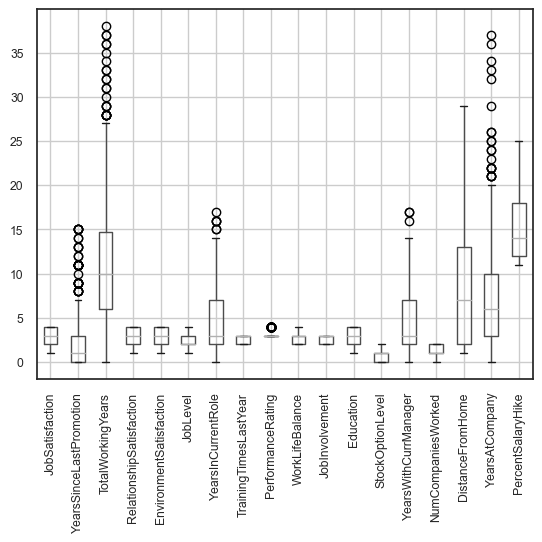

<Figure size 640x480 with 0 Axes>

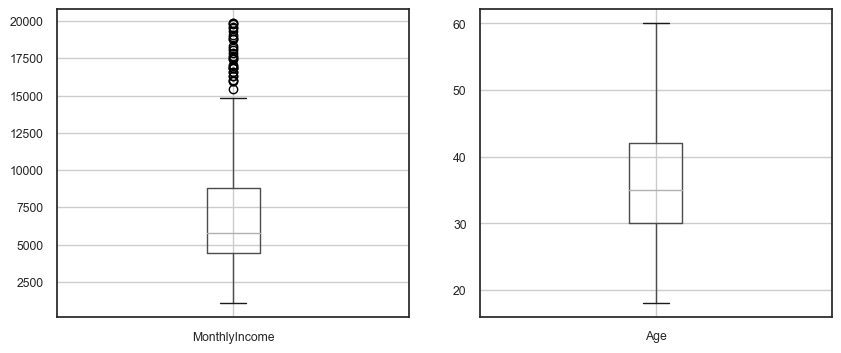

In [191]:
# outlier box plot 
numeric_columns = list(X_Sales.select_dtypes(include=['int64', 'float64']).columns)
#print(numeric_columns)

data_Sales.boxplot(column=list(set(numeric_columns) - {"MonthlyIncome", "Age"}), rot = 90)
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
pd.DataFrame(data_Sales["MonthlyIncome"]).boxplot(column="MonthlyIncome", ax=ax[0])
pd.DataFrame(data_Sales["Age"]).boxplot(column="Age", ax=ax[1])
plt.show()

In [194]:
# outlier -> non outliers max value transformation
outlier_group_list = ["YearsInCurrentRole", "YearsWithCurrManager", "TotalWorkingYears", "YearsAtCompany", "MonthlyIncome", "YearsSinceLastPromotion", "TrainingTimesLastYear", "NumCompaniesWorked"]

for i in outlier_group_list :
    q1 = np.percentile(data_Sales[i],25)
    q3 = np.percentile(data_Sales[i],75)
    iqr = q3-q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    data_Sales.loc[data_Sales[i] > upper_bound, i] = upper_bound
    data_Sales.loc[data_Sales[i] < lower_bound, i] = lower_bound

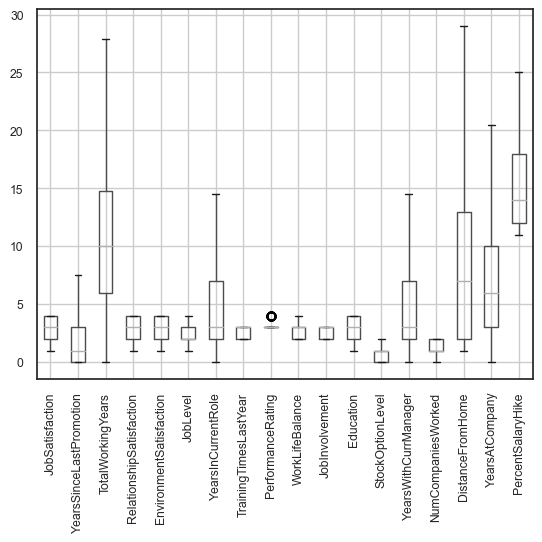

<Figure size 640x480 with 0 Axes>

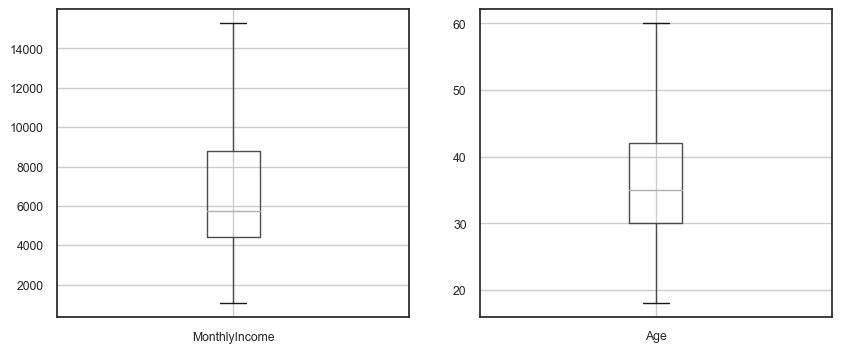

In [195]:
# Check outliers again
numeric_columns = list(X_Sales.select_dtypes(include=['int64', 'float64']).columns)

data_Sales.boxplot(column=list(set(numeric_columns) - {"MonthlyIncome", "Age"}), rot = 90) 
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
pd.DataFrame(data_Sales["MonthlyIncome"]).boxplot(column="MonthlyIncome", ax=ax[0])
pd.DataFrame(data_Sales["Age"]).boxplot(column="Age", ax=ax[1])
plt.show()

In [196]:
# multicollinearity check 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

data_Sales = data_Sales.drop(columns = ["Department"])
X_Sales = X_Sales.drop(columns = ["Department"])

data_Sales = pd.concat([pd.DataFrame(y_Sales), pd.get_dummies(X_Sales)], axis=1) # dummy 생성
X_Sales = data_Sales.drop(columns = ["Attrition"])

# print(list(X_Sales.columns))

X_Sales_numeric = data_Sales.select_dtypes(include=['int64', 'float64']).drop(columns = "Attrition") # vif는 카테고리 안되므로 제거

vif_data = pd.DataFrame()
vif_data["feature"] = X_Sales_numeric.columns
# print(X_Sales_numeric.values) 
vif_data["VIF"] = [vif(X_Sales_numeric.values, i) for i in range(len(X_Sales_numeric.columns))] 
vif_data

['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male', 'OverTime_No', 'OverTime_Yes']
[[41  1  2 ...  4  0  5]
 [53  2  4 ...  8  3  7]
 [36  9  4 ...  3  0  3]
 ...
 [39 24  1 ...  9  9  6]
 [26  5  3 ...  2  0  0]
 [49  2  3 ...  6  0  8]]


,feature,VIF
0,Age,32.501658
1,DistanceFromHome,2.452590
2,Education,9.510560
3,EnvironmentSatisfaction,7.044548
4,JobInvolvement,15.724829
5,JobLevel,57.447972
6,JobSatisfaction,7.023069
7,MonthlyIncome,33.738391
8,NumCompaniesWorked,2.687388
9,PercentSalaryHike,40.539879


<Axes: >

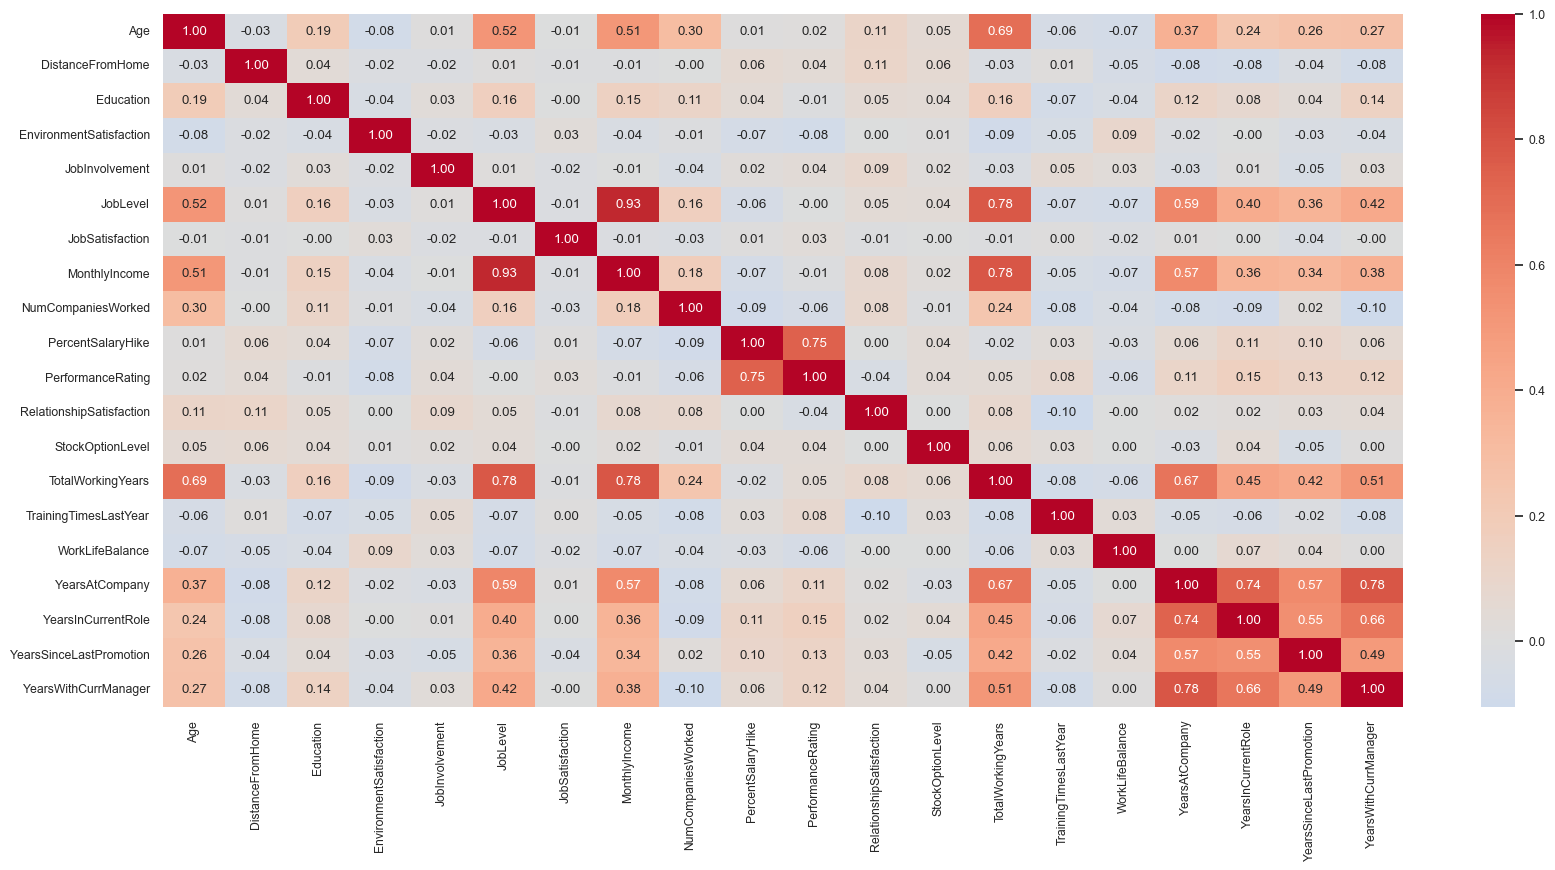

In [197]:
# corr matrix (pearson)
corr_df = X_Sales[X_Sales_numeric.columns].corr() 
corr_df_x = corr_df.sort_index().sort_index(axis=1) 
plt.figure(figsize=(20,9))
sns.heatmap(corr_df_x, annot=True, fmt=".2f", cmap="coolwarm", center=0) 

<Axes: >

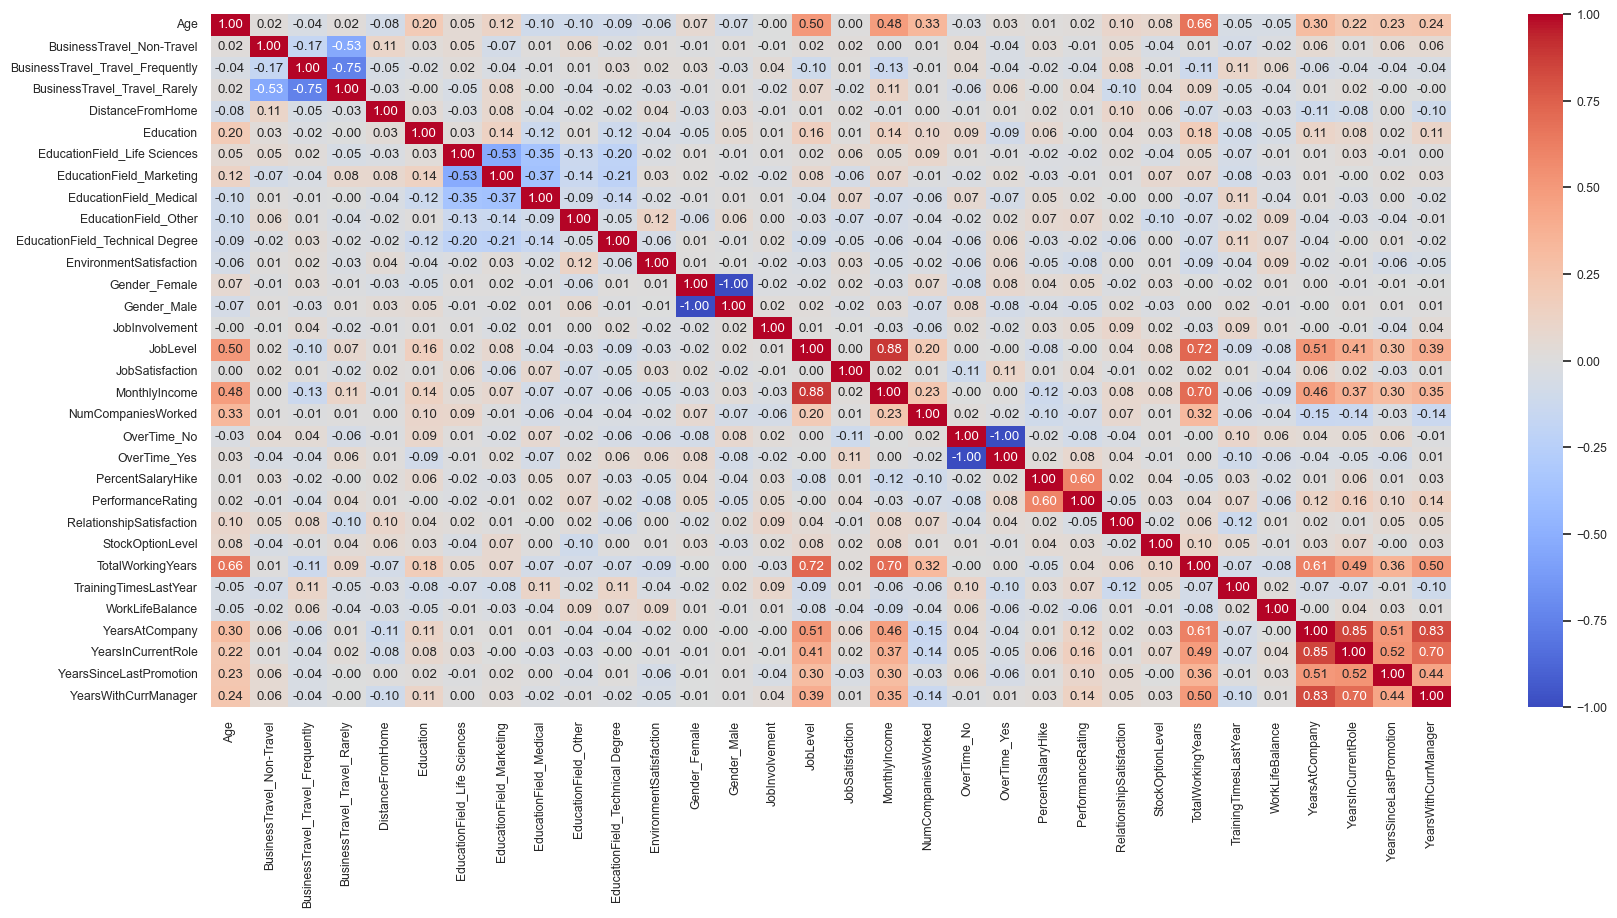

In [198]:
# corr matrix (spearman)
corr_df1 = X_Sales.corr(method="spearman")
corr_df_x1 = corr_df1.sort_index().sort_index(axis=1) 
plt.figure(figsize=(20,9))
sns.heatmap(corr_df_x1, annot=True, fmt=".2f", cmap="coolwarm", center=0) 

In [200]:
# > vif(model) from R for GVIF check up 

#                              GVIF Df GVIF^(1/(2*Df))
# Age                      2.093975  1        1.447057
# BusinessTravel           1.120148  2        1.028771
# DistanceFromHome         1.075957  1        1.037283
# Education                1.117731  1        1.057228
# EducationField           1.306826  4        1.034016
# EnvironmentSatisfaction  1.061107  1        1.030101
# Gender                   1.028764  1        1.014280
# JobInvolvement           1.040042  1        1.019825
# JobLevel                 8.780711  1        2.963226
# JobSatisfaction          1.040869  1        1.020230
# MonthlyIncome            8.901958  1        2.983615
# NumCompaniesWorked       1.289984  1        1.135775
# OverTime                 1.084976  1        1.041622
# PercentSalaryHike        2.390671  1        1.546179
# PerformanceRating        2.418295  1        1.555087
# RelationshipSatisfaction 1.089842  1        1.043955
# StockOptionLevel         1.061682  1        1.030380
# TotalWorkingYears        4.924478  1        2.219116
# TrainingTimesLastYear    1.107424  1        1.052342
# WorkLifeBalance          1.055221  1        1.027240
# YearsAtCompany           4.984140  1        2.232519
# YearsInCurrentRole       2.609916  1        1.615523
# YearsSinceLastPromotion  1.676664  1        1.294861
# YearsWithCurrManager     2.866362  1        1.693033

In [201]:
data_Sales.info()
X_Sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 0 to 1468
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   Attrition                         446 non-null    int64
 1   Age                               446 non-null    int64
 2   DistanceFromHome                  446 non-null    int64
 3   Education                         446 non-null    int64
 4   EnvironmentSatisfaction           446 non-null    int64
 5   JobInvolvement                    446 non-null    int64
 6   JobLevel                          446 non-null    int64
 7   JobSatisfaction                   446 non-null    int64
 8   MonthlyIncome                     446 non-null    int64
 9   NumCompaniesWorked                446 non-null    int64
 10  PercentSalaryHike                 446 non-null    int64
 11  PerformanceRating                 446 non-null    int64
 12  RelationshipSatisfaction          446 no

(356,) (69,)
0.23267033564857453
[0.2220255  0.09332968]
(356, 2)


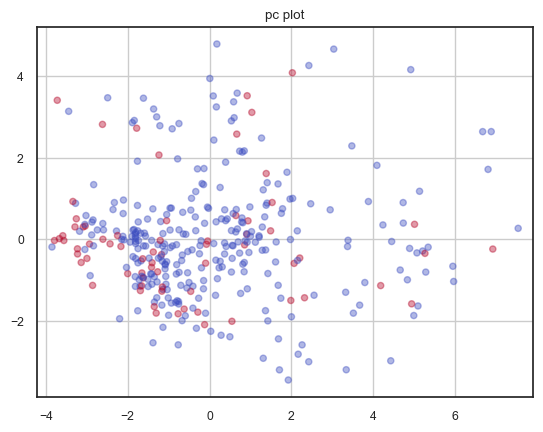

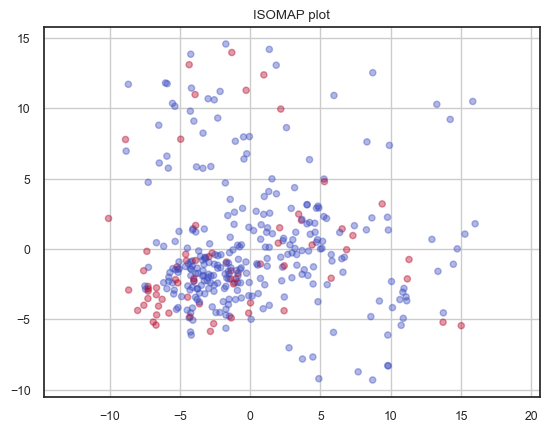

In [202]:
# check PCA, ISOMAP again for Sales dept data after outlier removal
X_train, X_test, y_train, y_test = train_test_split(X_Sales, y_Sales, train_size = 0.8, test_size=0.2, random_state=100)
X_train

X_train[X_Sales_numeric.columns] = StandardScaler().fit(X_train[X_Sales_numeric.columns]).transform(X_train[X_Sales_numeric.columns]) 
X_test[X_Sales_numeric.columns] = StandardScaler().fit(X_test[X_Sales_numeric.columns]).transform(X_test[X_Sales_numeric.columns]) 
print(y_train.shape, y_train[y_train==1].shape)

linear = LinearRegression()
linear.fit(X_train, y_train)
print(linear.score(X_train, y_train)) # 0.23267033564857453 non linear 


# PCA
pca = PCA(n_components =2).fit(X_train)
pc = pca.transform(X_train)
print(pca.explained_variance_ratio_) 
print(pc.shape) 

plt.figure()
plt.scatter(pc[:,0], pc[:,1], s=20, c=y_train, alpha = 0.4, cmap = "coolwarm")
plt.axis('equal')
plt.grid()
plt.title('pc plot')
plt.show() 

# ISOMAP
isomap = Isomap(n_components=2, n_neighbors=5)
X_reduced = isomap.fit_transform(X_train)

plt.figure()
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=20, c=y_train, alpha = 0.4, cmap = "coolwarm")
plt.axis('equal')
plt.grid()
plt.title('ISOMAP plot')
plt.show() 


In [203]:
X_train.columns

Index(['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'OverTime_No', 'OverTime_Yes'],
      dtype='object')

In [205]:
# feature selection 
# Lasso
lasso_model = LassoCV(cv=100, random_state=7406, max_iter=10000)


X_Sales[X_Sales_numeric.columns] = StandardScaler().fit(X_Sales[X_Sales_numeric.columns]).transform(X_Sales[X_Sales_numeric.columns]) 

lasso_model.fit(X_Sales, y_Sales)
opt_alpha = lasso_model.alpha_ 
print(opt_alpha) 

lasso_opt_model = Lasso(alpha=opt_alpha)
lasso_opt_model.fit(X_Sales, y_Sales) 

pd.DataFrame({"variable" :list(X_train.columns), "coef":lasso_opt_model.coef_,})
#X_train


0.0037471691887456275


,variable,coef
0,Age,-3.428366e-02
1,DistanceFromHome,3.388175e-02
2,Education,0.000000e+00
3,EnvironmentSatisfaction,-4.918857e-02
4,JobInvolvement,-5.675174e-02
5,JobLevel,-1.494168e-02
6,JobSatisfaction,-4.729495e-02
7,MonthlyIncome,-0.000000e+00
8,NumCompaniesWorked,4.483986e-02
9,PercentSalaryHike,0.000000e+00


In [227]:
# LASSO opt parameter with logit 

X_Sales_lasso = X_Sales.drop(columns=["Education", "JobLevel", "PercentSalaryHike", "BusinessTravel_Travel_Rarely", "EducationField_Life Sciences", "EducationField_Other", "EducationField_Technical Degree", "Gender_Male"])
X_Sales_lasso_numeric = X_Sales_lasso.select_dtypes(include=['int64', 'float64']) #

lasso_result = []

np.random.seed(42)

for c in range(50) :
#     X_train, X_test, y_train, y_test = train_test_split(X_Sales_Kbest, y_Sales, train_size = 0.8, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X_Sales_lasso, y_Sales, train_size = 0.8, test_size=0.2)

    X_train[X_Sales_lasso_numeric.columns] = StandardScaler().fit(X_train[X_Sales_lasso_numeric.columns]).transform(X_train[X_Sales_lasso_numeric.columns]) # 
    X_test[X_Sales_lasso_numeric.columns] = StandardScaler().fit(X_test[X_Sales_lasso_numeric.columns]).transform(X_test[X_Sales_lasso_numeric.columns]) # 
    
    logit = LogisticRegression()
    lasso_logit_fit = logit.fit(X_train, y_train).predict_proba(X_test)
    lasso_logit_roc = roc_auc_score(y_test, lasso_logit_fit[:,1])
    lasso_result.append(lasso_logit_roc)

np.mean(lasso_result)

0.7930933037118428

In [272]:
X_Sales_lasso.columns

Index(['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'EducationField_Marketing',
       'EducationField_Medical', 'Gender_Female', 'OverTime_No',
       'OverTime_Yes'],
      dtype='object')

In [228]:
# feature selection 
# Univariate selection method (SelectKBest) with logit

from sklearn.feature_selection import SelectKBest

kselect = len(X_Sales.columns)
kselect_result = {"round":[], "k":[], "variables":[], "logit_roc":[]}

np.random.seed(42)

for c in range(50) :
#     X_train, X_test, y_train, y_test = train_test_split(X_Sales_Kbest, y_Sales, train_size = 0.8, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X_Sales, y_Sales, train_size = 0.8, test_size=0.2)

    X_train[X_Sales_numeric.columns] = StandardScaler().fit(X_train[X_Sales_numeric.columns]).transform(X_train[X_Sales_numeric.columns]) 
    X_test[X_Sales_numeric.columns] = StandardScaler().fit(X_test[X_Sales_numeric.columns]).transform(X_test[X_Sales_numeric.columns]) 
    
    for k in range(kselect) :
        selector  = SelectKBest(k=k+1)
        K_best_new = selector.fit_transform(X_train, y_train)
        selected_mask = selector.get_support()
        kselect_result["round"].append(c)
        kselect_result["k"].append(k)
        kselect_result["variables"].append(list(set(X_train.columns) - set(X_train.columns[selected_mask])))

        X_train_selected, X_test_selected = X_train[X_train.columns[selected_mask]], X_test[X_test.columns[selected_mask]]
        logit = LogisticRegression()
        kselect_logit_fit = logit.fit(X_train_selected, y_train).predict_proba(X_test_selected)
        kselect_logit_roc = roc_auc_score(y_test, kselect_logit_fit[:,1])
        kselect_result["logit_roc"].append(kselect_logit_roc)

#kselect_result

In [229]:
pd.DataFrame(kselect_result).groupby(["k"])["logit_roc"].mean()

k
0     0.642245
1     0.642245
2     0.650022
3     0.664462
4     0.681310
5     0.693882
6     0.705000
7     0.716988
8     0.727488
9     0.731032
10    0.733335
11    0.743714
12    0.746109
13    0.748716
14    0.753809
15    0.758382
16    0.766113
17    0.768366
18    0.771776
19    0.772531
20    0.774388
21    0.773033
22    0.776871
23    0.777390
24    0.779159
25    0.779825
26    0.780777
27    0.781981
28    0.781639
29    0.780987
30    0.782301
31    0.781669
Name: logit_roc, dtype: float64

In [1]:
# 30 features seems to be the best

In [230]:
pd.DataFrame(kselect_result).groupby("k").get_group(30)["variables"].value_counts() 

variables
[RelationshipSatisfaction]           10
[PercentSalaryHike]                   8
[EducationField_Life Sciences]        7
[Gender_Female]                       5
[EducationField_Other]                5
[YearsSinceLastPromotion]             5
[EducationField_Marketing]            4
[Gender_Male]                         2
[PerformanceRating]                   2
[WorkLifeBalance]                     1
[EducationField_Technical Degree]     1
Name: count, dtype: int64

In [267]:
# feature selection 
# Tree-based selection method (ExtraTreeClassifier) with logit

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

clf_result_num = {}

for i in range(len(X_Sales.columns)) :
    clf = ExtraTreesClassifier(n_estimators=100)
    clf_fit = clf.fit(X_Sales, y_Sales)
    clf_features = pd.DataFrame(clf_fit.feature_importances_, index=list(X_Sales.columns), columns=["features"]).sort_values(by="features", ascending=False)
    clf_selected_features = clf_features.head(i+1).index # 
    X_Sales_clf = X_Sales[clf_selected_features]
    X_Sales_clf_numeric = X_Sales_clf.select_dtypes(include=("int64", "float"))

    clf_result = []
    clf_coef = {}

    np.random.seed(42)

    for c in range(50) :
    #     X_train, X_test, y_train, y_test = train_test_split(X_Sales_Kbest, y_Sales, train_size = 0.8, test_size=0.2)
        X_train, X_test, y_train, y_test = train_test_split(X_Sales_clf, y_Sales, train_size = 0.8, test_size=0.2)

        X_train[X_Sales_clf_numeric.columns] = StandardScaler().fit(X_train[X_Sales_clf_numeric.columns]).transform(X_train[X_Sales_clf_numeric.columns])
        X_test[X_Sales_clf_numeric.columns] = StandardScaler().fit(X_test[X_Sales_clf_numeric.columns]).transform(X_test[X_Sales_clf_numeric.columns]) 

        logit = LogisticRegression()
        clf_fit = logit.fit(X_train, y_train).predict_proba(X_test)
        clf_logit_roc = roc_auc_score(y_test, clf_fit[:,1])
        clf_result.append(clf_logit_roc)
        clf_coef[c]=clf.feature_importances_
    clf_result_num[i+1] = np.mean(clf_result)

print(clf_result_num)

{0: 0.6413729720926896, 1: 0.6505727254237174, 2: 0.6623517010092493, 3: 0.6655883514919338, 4: 0.6803269256452908, 5: 0.6945628448535075, 6: 0.7569105866570414, 7: 0.7517151001913536, 8: 0.7691962479044997, 9: 0.7669062678535771, 10: 0.7642655932934826, 11: 0.7652030799396775, 12: 0.763676530341123, 13: 0.7671159452833224, 14: 0.7669864888796784, 15: 0.7674252516430805, 16: 0.7727158783758266, 17: 0.7714968374403678, 18: 0.7719517404542141, 19: 0.7694616921008561, 20: 0.7914238828806404, 21: 0.788184166821355, 22: 0.7844492536206495, 23: 0.7821528347963951, 24: 0.7828544043514966, 25: 0.7827870340355888, 26: 0.7832414593298579, 27: 0.7818162331885595, 28: 0.7808180845882096, 29: 0.7795643527891428, 30: 0.7825601899717401, 31: 0.7816690117337727}


In [268]:
max_key = max(clf_result_num, key=clf_result_num.get)
max_value = clf_result_num[max_key]
max_key, max_value

(20, 0.7914238828806404)

In [279]:
# feature selection 
# Backward Elimination 
from sklearn.feature_selection import SequentialFeatureSelector

logit = LogisticRegression()
    
sfs = SequentialFeatureSelector(logit, direction="backward", scoring='roc_auc', cv=5)
sfs_fit = sfs.fit(X_Sales, y_Sales)

sfs_fit.get_feature_names_out()

<bound method SelectorMixin.get_feature_names_out of SequentialFeatureSelector(direction='backward', estimator=LogisticRegression(),
                          scoring='roc_auc')>

In [282]:
# selected features
sfs_fit.get_feature_names_out()

array(['Age', 'DistanceFromHome', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobSatisfaction', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'Gender_Male', 'OverTime_Yes'], dtype=object)

In [288]:
# unselected features
set(X_Sales.columns)-set(list(sfs_fit.get_feature_names_out())) 

{'BusinessTravel_Travel_Rarely',
 'Education',
 'EducationField_Life Sciences',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_Technical Degree',
 'Gender_Female',
 'JobLevel',
 'MonthlyIncome',
 'OverTime_No',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole'}

In [293]:
# Backward Elimination w/ chosen features w/ logit

X_Sales_sfs = X_Sales[sfs_fit.get_feature_names_out()]
X_Sales_sfs_numeric = X_Sales_sfs.select_dtypes(include=['int64', 'float64'])

sfs_result = []

np.random.seed(42)

for c in range(50) :
#     X_train, X_test, y_train, y_test = train_test_split(X_Sales_Kbest, y_Sales, train_size = 0.8, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X_Sales_sfs, y_Sales, train_size = 0.8, test_size=0.2)

    X_train[X_Sales_sfs_numeric.columns] = StandardScaler().fit(X_train[X_Sales_sfs_numeric.columns]).transform(X_train[X_Sales_sfs_numeric.columns]) 
    X_test[X_Sales_sfs_numeric.columns] = StandardScaler().fit(X_test[X_Sales_sfs_numeric.columns]).transform(X_test[X_Sales_sfs_numeric.columns]) 
    
    logit = LogisticRegression()
    sfs_logit_fit = logit.fit(X_train, y_train).predict_proba(X_test)
    sfs_logit_roc = roc_auc_score(y_test, sfs_logit_fit[:,1])
    sfs_result.append(sfs_logit_roc)

np.mean(sfs_result)

0.7989845800979283

In [ ]:
# Backward Elimination result is the best, therefore selected features are used for future modleing

0.25473406662696585
[0.15293175 0.12880361]
(446, 2)


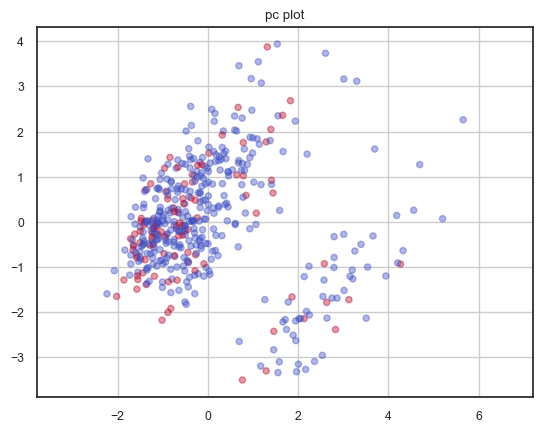

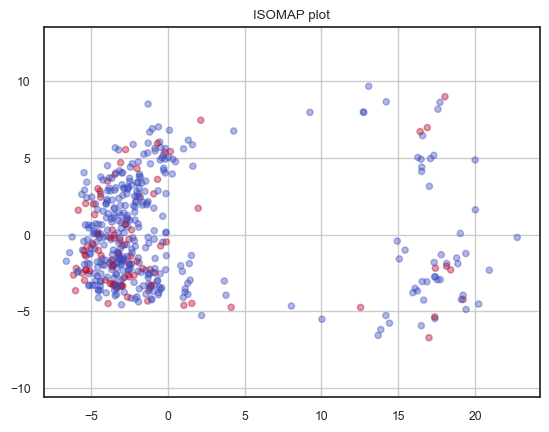

In [361]:
# Check PCA, ISOMAP again w/ selected features
linear = LinearRegression()
linear.fit(X_Sales_sfs, y_Sales)
print(linear.score(X_Sales_sfs, y_Sales)) # 0.1828241971766883 non linear 


# PCA
pca = PCA(n_components =2).fit(X_Sales_sfs)
pc = pca.transform(X_Sales_sfs)
print(pca.explained_variance_ratio_) # 
print(pc.shape) #

plt.figure()
plt.scatter(pc[:,0], pc[:,1], s=20, c=y_Sales, alpha = 0.4, cmap = "coolwarm")
plt.axis('equal')
plt.grid()
plt.title('pc plot')
plt.show() 

# ISOMAP
isomap = Isomap(n_components=2, n_neighbors=5)
X_reduced = isomap.fit_transform(X_Sales_sfs)

plt.figure()
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=20, c=y_Sales, alpha = 0.4, cmap = "coolwarm")
plt.axis('equal')
plt.grid()
plt.title('ISOMAP plot')
plt.show() 

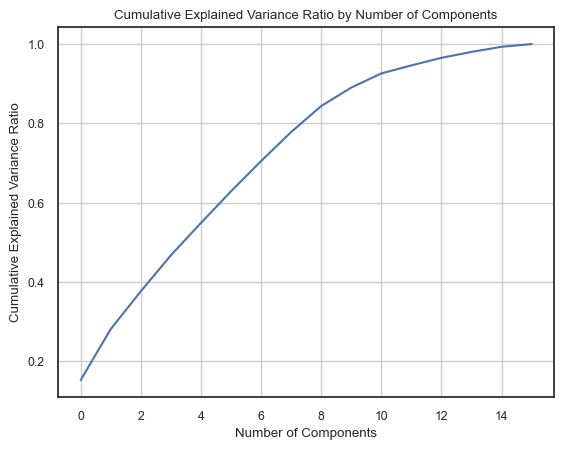

In [356]:
# parameter tunning
# PCA 

X_train, X_test, y_train, y_test = train_test_split(X_Sales_sfs, y_Sales, train_size = 0.8, test_size=0.2)

X_train[X_Sales_sfs_numeric.columns] = StandardScaler().fit(X_train[X_Sales_sfs_numeric.columns]).transform(X_train[X_Sales_sfs_numeric.columns]) 
X_test[X_Sales_sfs_numeric.columns] = StandardScaler().fit(X_test[X_Sales_sfs_numeric.columns]).transform(X_test[X_Sales_sfs_numeric.columns]) 
  

pca = PCA().fit(X_train) 
pca1 = PCA().fit(X_test)

pc = pca.transform(X_train) 
pc.shape # (313, 6) 
pc1 = pca.transform(X_test) 

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.show()

# pc = 12

In [378]:
# parameter tunning (ensemble models)

from sklearn.tree import DecisionTreeClassifier
np.random.seed(42)
model_params = {"GBM": {'model': GradientBoostingClassifier(random_state=42),
                        'params': { 'learning_rate': list(np.arange(0.01,0.05,0.01)),
                                    'n_estimators': [200, 500, 700] , 
                                    'subsample':[0.1, 0.25, 0.5, 1], 
                                   'min_samples_leaf': [1, 2, 3, 5],
                                    'max_depth':[2, 3, 5, 10, 15] 
                                  }},
                "AdaBoost": {'model': AdaBoostClassifier(random_state=42),
                        'params': {'estimator': [DecisionTreeClassifier(max_depth=i) for i in range(1,11,2)], 
                                   'n_estimators':[2, 5, 10, 20],  
                                   'learning_rate':list(np.arange(0.01,0.05,0.01))}},
                "RF": {'model' : RandomForestClassifier(random_state=42),
                       'params' : {'n_estimators' : [20, 35, 50, 70],
                        'min_samples_leaf' : [1, 2, 3, 5],
                       'min_samples_split' : [2, 3, 4, 5],
                        'max_depth' : [10, 13, 15, 20]}}
                
                                  }

In [379]:
# GridSearchCV

best_para = []
np.random.seed(42)
for name, model in model_params.items() :
    model_fit = model["model"]
    grid_rf = GridSearchCV(model_fit, model['params'], cv=5)
    grid_rf.fit(X_train, y_train)
    best_para.append(grid_rf.best_params_) # {'min_samples_split': 20, 'n_estimators': 100}



In [380]:
# best parameters
best_para

[{'learning_rate': 0.03,
  'max_depth': 2,
  'min_samples_leaf': 3,
  'n_estimators': 500,
  'subsample': 0.25},
 {'estimator': DecisionTreeClassifier(max_depth=1),
  'learning_rate': 0.02,
  'n_estimators': 2},
 {'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50}]

In [1209]:
X_Sales.columns

Index(['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'OverTime_No', 'OverTime_Yes'],
      dtype='object')

In [1188]:
# Build models

In [381]:
cv_result = {'lda':[], 'qda' :[], 'naive_bayes':[], 'logit':[], 'knn':[], 'pca_knn':[], 'rf':[], "GBM":[], "AdaBoost":[]}
cv_result_train = {'lda':[], 'qda' :[], 'naive_bayes':[], 'logit':[], 'knn':[], 'pca_knn':[], 'rf':[], "GBM":[], "AdaBoost":[]}
cv_coef = {'lda':{}, 'qda' :{}, 'naive_bayes':{}, 'logit':{}, 'knn':{}, 'pca_knn':{}, 'rf':{}, "GBM":{}, "AdaBoost":{}}

cv_range = 100
np.random.seed(10)

for i in range(cv_range) :
    print(i)

    # training/test set split
    X_train, X_test, y_train, y_test = train_test_split(X_Sales_sfs, y_Sales, train_size = 0.8, test_size=0.2) 
    
    x_numerical_col = X_Sales.select_dtypes(include=['int64', 'float64']).columns
    
    # standardization
    scaler = StandardScaler().fit(X_train[X_Sales_sfs_numeric.columns]) 

    X_train[X_Sales_sfs_numeric.columns] = scaler.transform(X_train[X_Sales_sfs_numeric.columns])
    X_test[X_Sales_sfs_numeric.columns] = scaler.transform(X_test[X_Sales_sfs_numeric.columns])
    
    models = {
    'lda': LinearDiscriminantAnalysis(solver='svd'),
    'qda': QuadraticDiscriminantAnalysis(),
    'naive_bayes': GaussianNB(),
    'logit': LogisticRegression(),
    'knn': KNeighborsClassifier,
    'rf' : RandomForestClassifier(random_state=42, **best_para[2]), 
    'GBM' : GradientBoostingClassifier(random_state=42, **best_para[0]), 
    "AdaBoost":AdaBoostClassifier(random_state=42, **best_para[1])}
    
    for name, model in models.items() :
        if name == "knn" :
            pca = PCA().fit(X_train)
            pc = pca.transform(X_test)
            pca1 = PCA().fit(X_test)
            pc1 = pca.transform(X_train)
    
            pca_knn_performance = {}
            pca_knn_performance_train = {}
            knn_performance = {}
            knn_performance_train = {}
            for k in range(1, 40, 2):
                knn_model= model(n_neighbors=k)
                # knn
                y_pred_knn = knn_model.fit(X_train.values, y_train).predict_proba(X_test.values)
                knn_roc = roc_auc_score(y_test, y_pred_knn[:,1])
                knn_performance[k] = knn_roc
                y_pred_knn_train = knn_model.fit(X_train.values, y_train).predict_proba(X_train.values)
                knn_roc_train = roc_auc_score(y_train, y_pred_knn_train[:,1])
                knn_performance_train[k] = knn_roc_train
                # pca knn
                y_pred_pca_knn = knn_model.fit(pc1[:,:12], y_train).predict_proba(pc[:,:12])
                pca_knn_roc = roc_auc_score(y_test, y_pred_pca_knn[:,1])
                pca_knn_performance[k] = pca_knn_roc
                y_pred_pca_knn_train = knn_model.fit(pc1[:,:12], y_train).predict_proba(pc1[:,:12])
                pca_knn_roc_train = roc_auc_score(y_train, y_pred_pca_knn_train[:,1])
                pca_knn_performance_train[k] = pca_knn_roc_train
            cv_result["knn"].append(knn_performance)
            cv_result_train["knn"].append(knn_performance_train)  
            cv_result["pca_knn"].append(pca_knn_performance)
            cv_result_train["pca_knn"].append(pca_knn_performance_train)
        else :
            model_fit = model.fit(X_train, y_train).predict_proba(X_test)
            model_roc = roc_auc_score(y_test, model_fit[:,1])
            cv_result[name].append(model_roc)
            if name not in ["qda", "naive_bayes", "rf", "GBM", "AdaBoost"] :
                cv_coef[name][i] = model.fit(X_train, y_train).coef_[0]
            if name in ["rf", "GBM", "AdaBoost"] :
                cv_coef[name][i] = model.fit(X_train, y_train).feature_importances_
            model_fit_train = model.fit(X_train, y_train).predict_proba(X_train)
            model_roc_train = roc_auc_score(y_train, model_fit_train[:,1])
            cv_result_train[name].append(model_roc_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [382]:
from collections import defaultdict
result = [cv_result_train, cv_result]

cv_result_mean = {'lda':[], 'qda' :[], 'naive_bayes':[], 'logit':[], 'knn':[], 'pca_knn':[], 'rf':[], "GBM":[], "AdaBoost":[], "Light GBM":[], "Catboost":[]}
cv_result_mean["knn"].append(defaultdict(float))
cv_result_mean["knn"].append(defaultdict(float))
cv_result_mean["pca_knn"].append(defaultdict(float))
cv_result_mean["pca_knn"].append(defaultdict(float))
for i in range(len(result)) :
    for model in result[i] :
        if model == "knn" or model == "pca_knn" :
            for eachcv in result[i][model] :
                for k, roc in eachcv.items() :
#                     print(cv_result_mean[model][i][k])
                    cv_result_mean[model][i][k] += roc
            for k in cv_result_mean[model][i] :
                cv_result_mean[model][i][k] /= cv_range
        else :
            cv_result_mean[model].append(np.mean(result[i][model]))

cv_result_mean


{'lda': [0.8400308991971602, 0.8094418170484097],
 'qda': [0.9159962810577303, 0.7067807137954023],
 'naive_bayes': [0.8000712332606181, 0.7438574187194181],
 'logit': [0.8442400022994971, 0.8097805159972364],
 'knn': [defaultdict(float,
              {1: 1.0,
               3: 0.904198536603658,
               5: 0.8539825748772646,
               7: 0.830062693460447,
               9: 0.8146540974073431,
               11: 0.7994994750508668,
               13: 0.786726621771213,
               15: 0.7812378815749116,
               17: 0.7780422034685954,
               19: 0.7772614242143088,
               21: 0.7785301639468314,
               23: 0.7791026706520569,
               25: 0.7782968212950392,
               27: 0.7797704873991325,
               29: 0.7815495084813946,
               31: 0.7807563044736028,
               33: 0.778124813322396,
               35: 0.7749402460015841,
               37: 0.7699771835883605,
               39: 0.764633479545385}),
  def

In [ ]:
# Logistic is the best

In [383]:
coef_mean = {}
#print(cv_coef["rf"])
#print(cv_coef["lda"])
for model in cv_coef :
    arrays = [v for k, v in cv_coef[model].items()]
    #print(len(arrays)) # 100
    if len(arrays) > 0:

        mean_array = np.mean(arrays, axis=0)

        coef_mean[model]=mean_array
    else :
        continue
coef_mean

{'lda': array([-0.47110595,  0.32084721, -0.4519089 , -0.49248283, -0.43192507,
         0.40306599,  0.08890913, -0.20930639, -0.09251818, -0.52349198,
         0.31383535, -0.48798951, -0.94635153,  1.30434165,  0.20641971,
         2.24330953]),
 'logit': array([-0.43947391,  0.3073754 , -0.42871148, -0.44222072, -0.37083325,
         0.33872956,  0.11164267, -0.21695894, -0.11036145, -0.48255942,
         0.39044449, -0.63422746, -0.92705315,  1.11936198,  0.18826166,
         1.84456176]),
 'rf': array([0.1366928 , 0.10936564, 0.05243836, 0.06537005, 0.06075232,
        0.07246081, 0.07410578, 0.0095059 , 0.05042818, 0.08042713,
        0.061112  , 0.08944791, 0.009266  , 0.03175659, 0.02288002,
        0.07399049]),
 'GBM': array([0.1855355 , 0.11535977, 0.04419168, 0.06654694, 0.05149458,
        0.068476  , 0.08323434, 0.0021172 , 0.03865842, 0.08406945,
        0.05763752, 0.08199251, 0.00444564, 0.02973032, 0.01343895,
        0.07307119]),
 'AdaBoost': array([0.04 , 0.   , 0

<Figure size 1000x600 with 0 Axes>

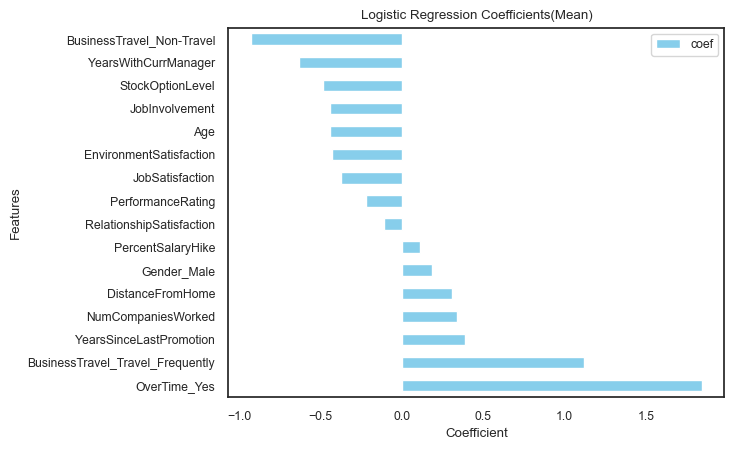

In [389]:
coef_df = pd.DataFrame(list(coef_mean["logit"]), index = X_Sales_sfs.columns, columns = ["coef"]).sort_values(by="coef",ascending=False)

plt.figure(figsize=(10, 6))
coef_df.plot(kind="barh", color="skyblue")
plt.xlabel("Coefficient")
plt.ylabel("Features")
plt.title("Logistic Regression Coefficients(Mean)")
plt.show()